In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
from ariadne.transformer.model import HFPerceiver
import ariadne.transformations  as trn
from ariadne.utils.model import get_checkpoint_path, weights_update
import torch
import seaborn as sns
import torch.nn.functional as f
%matplotlib notebook
%load_ext autoreload
%autoreload 2

Load data

In [2]:
params = {
                    "sep": '\s+',
                    #"nrows": 10000,
                    "encoding": 'utf-8',
                    "names":  ['event',  'x', 'y', 'z', 'station',
                               'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0', 'label']
                 }
data = pd.read_csv(os.path.join('D:/','data','spd','100.tsv'), **params)

In [3]:
data.head()

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,label
0,0,269.431318,-15.606005,-152.728159,1,0,724.078294,-73.264025,392.716216,-13.097227,-8.964861,-298.59262,NaN
1,0,278.715403,-16.526084,-147.889148,2,0,723.862082,-75.370282,392.716216,-13.097227,-8.964861,-298.59262,NaN
2,0,287.642596,-17.493598,-143.005710,3,0,723.639729,-77.476037,392.716216,-13.097227,-8.964861,-298.59262,NaN
3,0,296.631127,-18.484063,-138.177285,4,0,723.411234,-79.581278,392.716216,-13.097227,-8.964861,-298.59262,NaN
4,0,305.792096,-19.490117,-133.188242,5,0,723.176598,-81.685990,392.716216,-13.097227,-8.964861,-298.59262,NaN


In [4]:
def visualize_simple_3d(data, axes=['x','y','z'], titleAx=['X', 'Y', 'Z'], title=None, scatter_params_true=None, scatter_params_false=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    true_els = data[data['track']!=-1]
    false_els = data[data['track']==-1]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [92]:
events = data.groupby('event')

Let's check how event is loaded

<IPython.core.display.Javascript object>


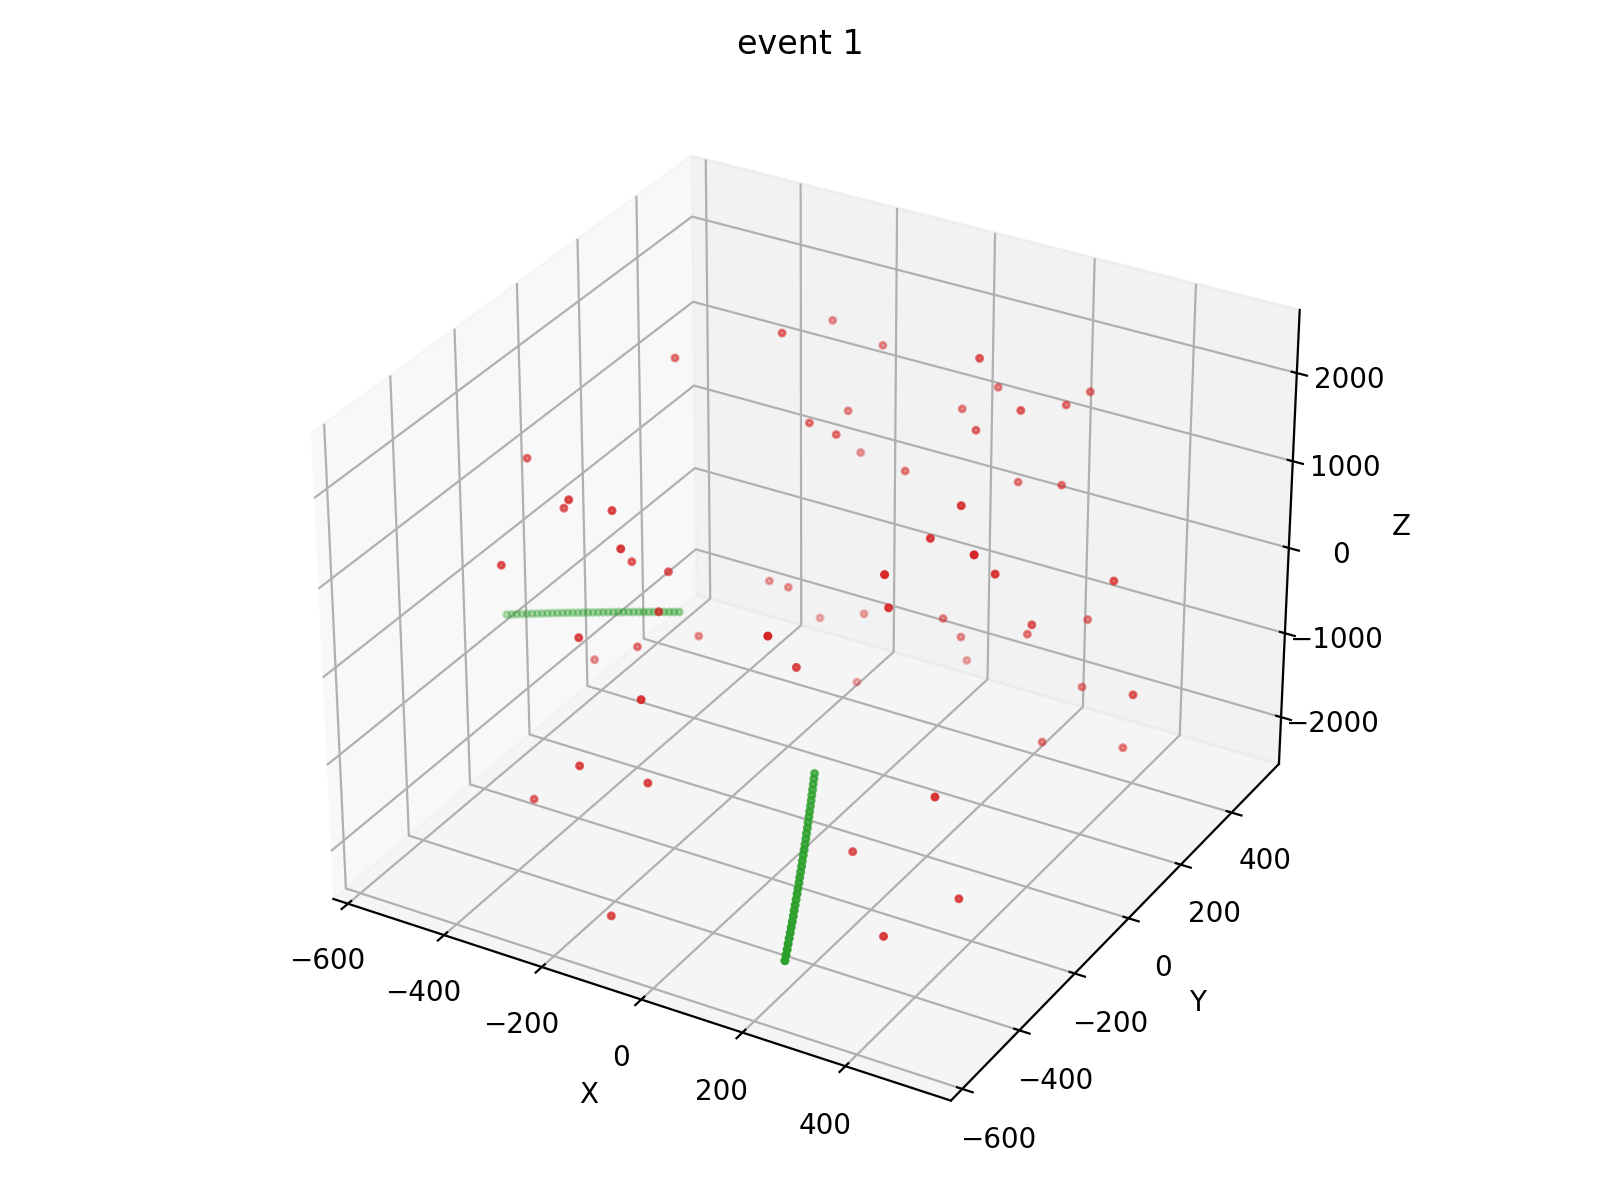

In [93]:
event_num = 6
visualize_simple_3d(data[data.event == event_num], title=f'event {event_num}', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5})

To change parameters of models (which are gin configurable) i enter interactive mode of gin (may be redundant)

In [6]:
gin.enter_interactive_mode()

Load model with basic parameters. Later check if model meets config file of checkpoint

In [7]:
model = HFPerceiver()
model = weights_update(model=model,
                           checkpoint=torch.load("D:\\projects\\ariadne\\lightning_logs\\HFPerceiver\\version_168\\epoch=36-step=37000.ckpt"))


Load event to test, perform necessary transformations.

In [8]:
event = data[data.event == 3]
transforms = trn.Compose([
    trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
    'x': [0., 600.], 'y': [0, 600.], 'z': [-2386., 2386.]
})])
event_t = transforms(event)

In [9]:
event_t

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,label,index
764,3,-1.872896,-0.780059,0.146687,1,0,-895.347204,193.384961,1309.490704,5.62164,3.188894,-36.073336,NaN,764
765,3,-1.902501,-0.773640,0.152156,2,0,-895.791664,191.315582,1309.490704,5.62164,3.188894,-36.073336,NaN,765
766,3,-1.932212,-0.767313,0.157587,3,0,-896.231360,189.245097,1309.490704,5.62164,3.188894,-36.073336,NaN,766
767,3,-1.962038,-0.761079,0.163052,4,0,-896.666289,187.173515,1309.490704,5.62164,3.188894,-36.073336,NaN,767
768,3,-1.991065,-0.754711,0.168590,5,0,-897.096447,185.100842,1309.490704,5.62164,3.188894,-36.073336,NaN,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,-2.746033,-1.587290,-0.414325,31,-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,976
977,3,0.180996,0.530694,0.159908,34,-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,977
978,3,-2.188831,-0.286952,-0.879103,16,-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,978
979,3,0.534106,-0.887363,-0.663210,21,-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,979


<IPython.core.display.Javascript object>


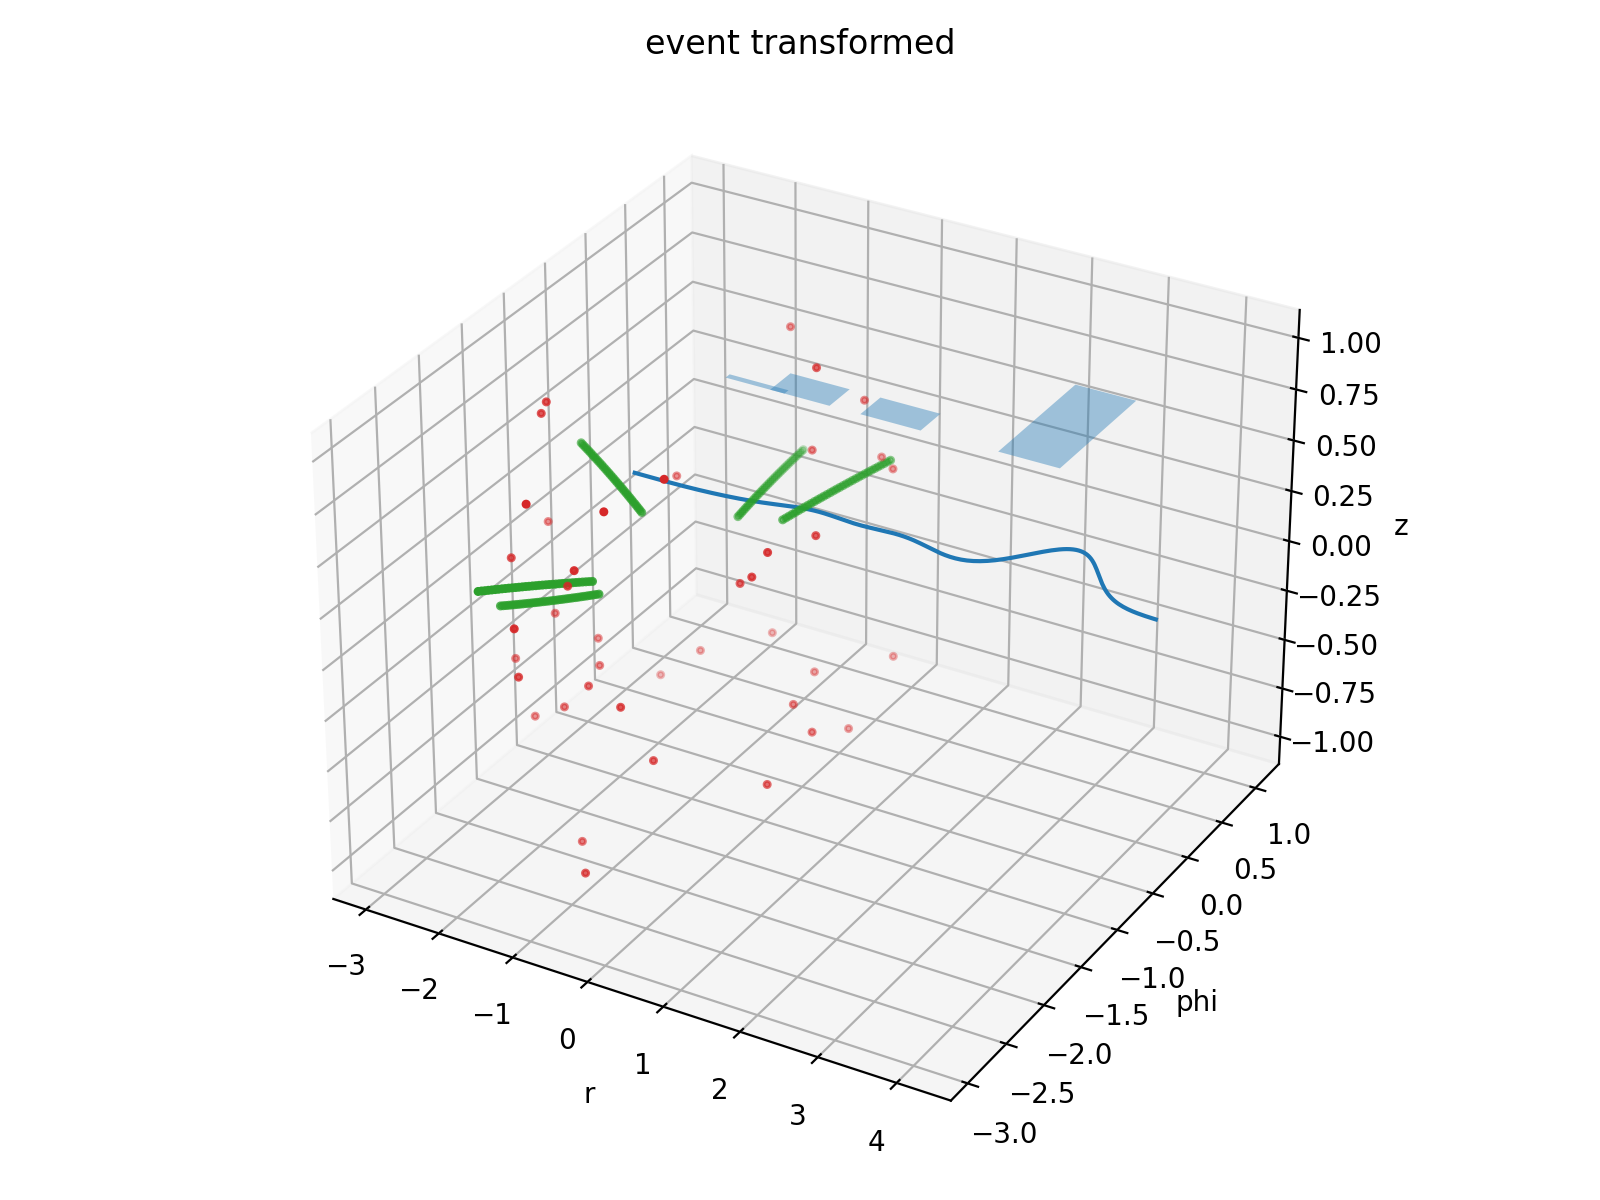

In [10]:
visualize_simple_3d(event_t, title='event transformed', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x','y', 'z'], titleAx=['r', 'phi', 'z'])

Change event to prepare x and y. X must be in format [ N, C]. This may change later after i fix input dimensions in model

In [11]:
event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T

In [12]:
event_y = event_t[event_t['track'] != -1]

In [13]:
event_x.shape

(3, 217)

In [14]:
input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()

In [15]:
input_event.size()

torch.Size([1, 217, 3])

Add zeros to get number of inputs suitable for model. Create mask to mask attention and metrics later.

In [16]:
event_changed = torch.zeros((input_event.size(0), 512, input_event.size(2)))
event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event

In [17]:
mask = torch.zeros((input_event.size(0), 512), dtype=torch.bool)
mask[:input_event.size(1)] = 1

In [18]:
inputs = {'x': event_changed, 'mask': mask }

In [19]:
inputs['x']

tensor([[[-1.8729, -0.7801,  0.1467],
         [-1.9025, -0.7736,  0.1522],
         [-1.9322, -0.7673,  0.1576],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

Produce outputs

In [20]:
result = model(x=inputs['x'], mask=inputs['mask'] )

In [21]:
result.shape

torch.Size([1, 512, 1])

In [22]:
result = result.squeeze()

In [23]:
result

tensor([ 2.7572,  2.7590,  2.7531,  2.7455,  2.7487,  2.7458,  2.7885,  2.7740,
         2.7419,  2.7324,  2.7853,  2.7486,  2.7205,  2.7482,  2.7386,  2.7480,
         2.7360,  2.7352,  2.7032,  2.7322,  2.7303,  2.7870,  2.7309,  2.7285,
         2.7258,  2.7357,  2.7339,  2.7309,  2.7539,  2.7549,  2.7405,  2.7631,
         2.7347,  2.7291,  2.7483,  2.6978,  2.7113,  2.6733,  2.6920,  2.7017,
         2.6901,  2.7003,  2.6700,  2.6702,  2.6868,  2.6804,  2.6871,  2.6949,
         2.6795,  2.6995,  2.6874,  2.6900,  2.6936,  2.6571,  2.6930,  2.6781,
         2.6561,  2.7018,  2.6702,  2.6802,  2.6963,  2.7036,  2.6979,  2.6982,
         2.6751,  2.6769,  2.7059,  2.7005,  2.6737,  2.6785,  2.6566,  2.6066,
         2.6373,  2.6578,  2.6419,  2.6271,  2.6021,  2.6233,  2.6606,  2.6449,
         2.6428,  2.6400,  2.6495,  2.6380,  2.6550,  2.6456,  2.6535,  2.6493,
         2.6368,  2.6330,  2.6352,  2.6400,  2.6343,  2.6045,  2.6087,  2.6326,
         2.6513,  2.6401,  2.6357,  2.64

In [24]:
result.detach().cpu().numpy()[:input_event.size(1)].max()

2.7884796

In [25]:
result.detach().cpu().numpy()[:input_event.size(1)].min()

-1.4519808

Check logits distribution

In [27]:
sns.distplot(result[:input_event.size(1)].detach().cpu().numpy())

<Axes3DSubplot: title={'center': 'event transformed'}, xlabel='r', ylabel='phi', zlabel='z'>

Get final result with scores and metrics

In [29]:
result = f.sigmoid(result) > 0.5

In [30]:
result = result.to(int)[:input_event.size(1)]

In [31]:
result 

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

In [32]:
labels = (event['track']!=-1).astype('int')
labels

764    1
765    1
766    1
767    1
768    1
      ..
976    0
977    0
978    0
979    0
980    0
Name: track, Length: 217, dtype: int32

In [33]:
labels.value_counts()

1    175
0     42
Name: track, dtype: int64

Точность по всему событию

In [34]:
(labels == np.array(result)).sum() / len(labels)

1.0

Точность по фейкам

In [35]:
fakes = labels < 1

In [36]:
(labels[fakes] == np.array(result)[fakes]).sum() / len(labels[fakes])

1.0

Точность по трекам

In [37]:
(labels[~fakes] == np.array(result)[~fakes]).sum() / len(labels[~fakes])

1.0

Общая визуализация

In [38]:
def visualize_preds_targets_3d(data_true,
                               preds,
                               axes=['x','y','z'], 
                               titleAx=['X', 'Y', 'Z'], 
                               title=None, 
                               scatter_params_true=None, 
                               scatter_params_false=None,
                               ):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    data_true['label'] = (data['track']!=-1).astype('int')
    true_els = data_true[data_true['label']==preds]
    false_els = data_true[data_true['label']!=preds]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


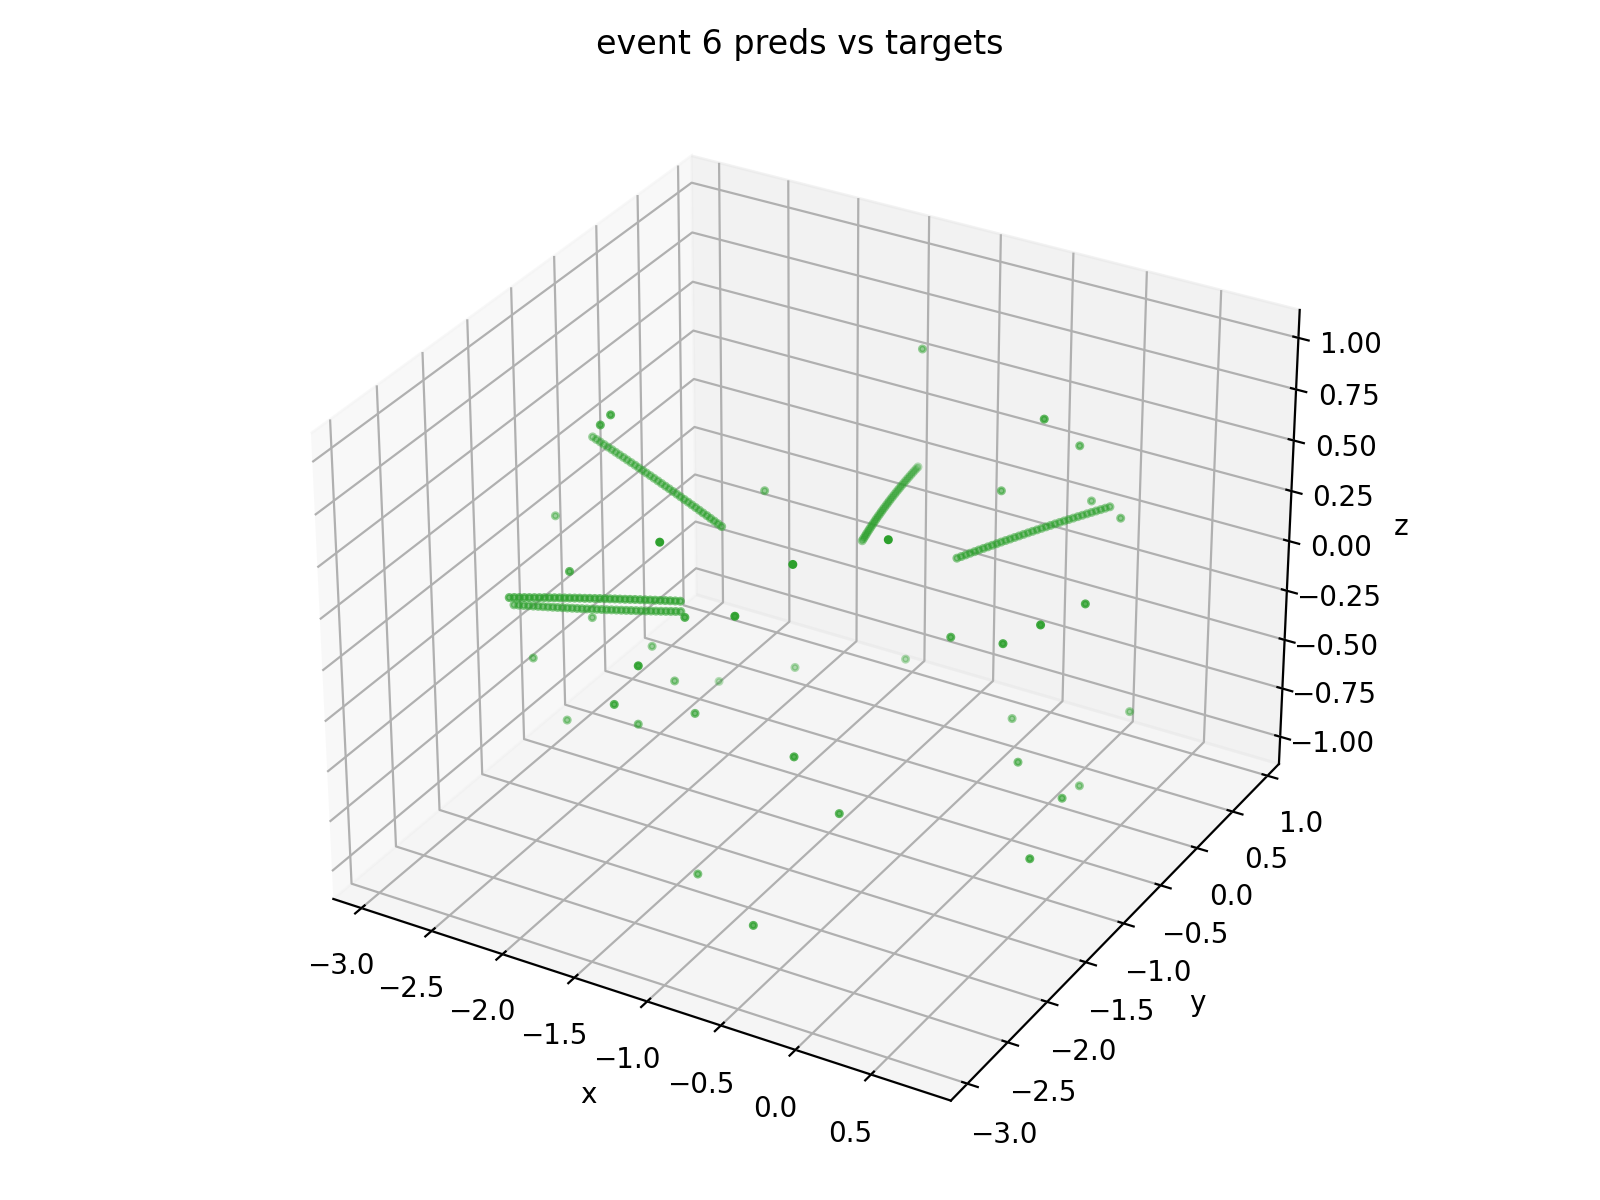

In [39]:
visualize_preds_targets_3d(event_t, np.array(result), title='event 6 preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [45]:
def get_results_for_event(event_num=3):
    event = data[data.event == event_num]
    transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [0., 600.], 'y': [0, 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T
    event_y = event_t[event_t['track'] != -1]
    input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()
    event_changed = torch.zeros((input_event.size(0), 512, input_event.size(2)))
    event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event
    mask = torch.zeros((input_event.size(0), 512), dtype=torch.bool)
    mask[:input_event.size(1)] = 1
    inputs = {'x': event_changed, 'mask': mask }
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = result.squeeze()
    result = f.sigmoid(result) > 0.5
    result = result.to(int)[:input_event.size(1)]
    labels = (event['track']!=-1).astype('int')
    print(f"Accuracy is {(labels == np.array(result)).sum() / len(labels)} ")
    print(f"Precision is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / np.array(result).sum()} ")
    print(f"Recall is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / labels.sum()} ")
    visualize_preds_targets_3d(event_t, np.array(result), title=f'event {event_num} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

Accuracy is 1.0 
Precision is 1.0 
Recall is 1.0 


<IPython.core.display.Javascript object>


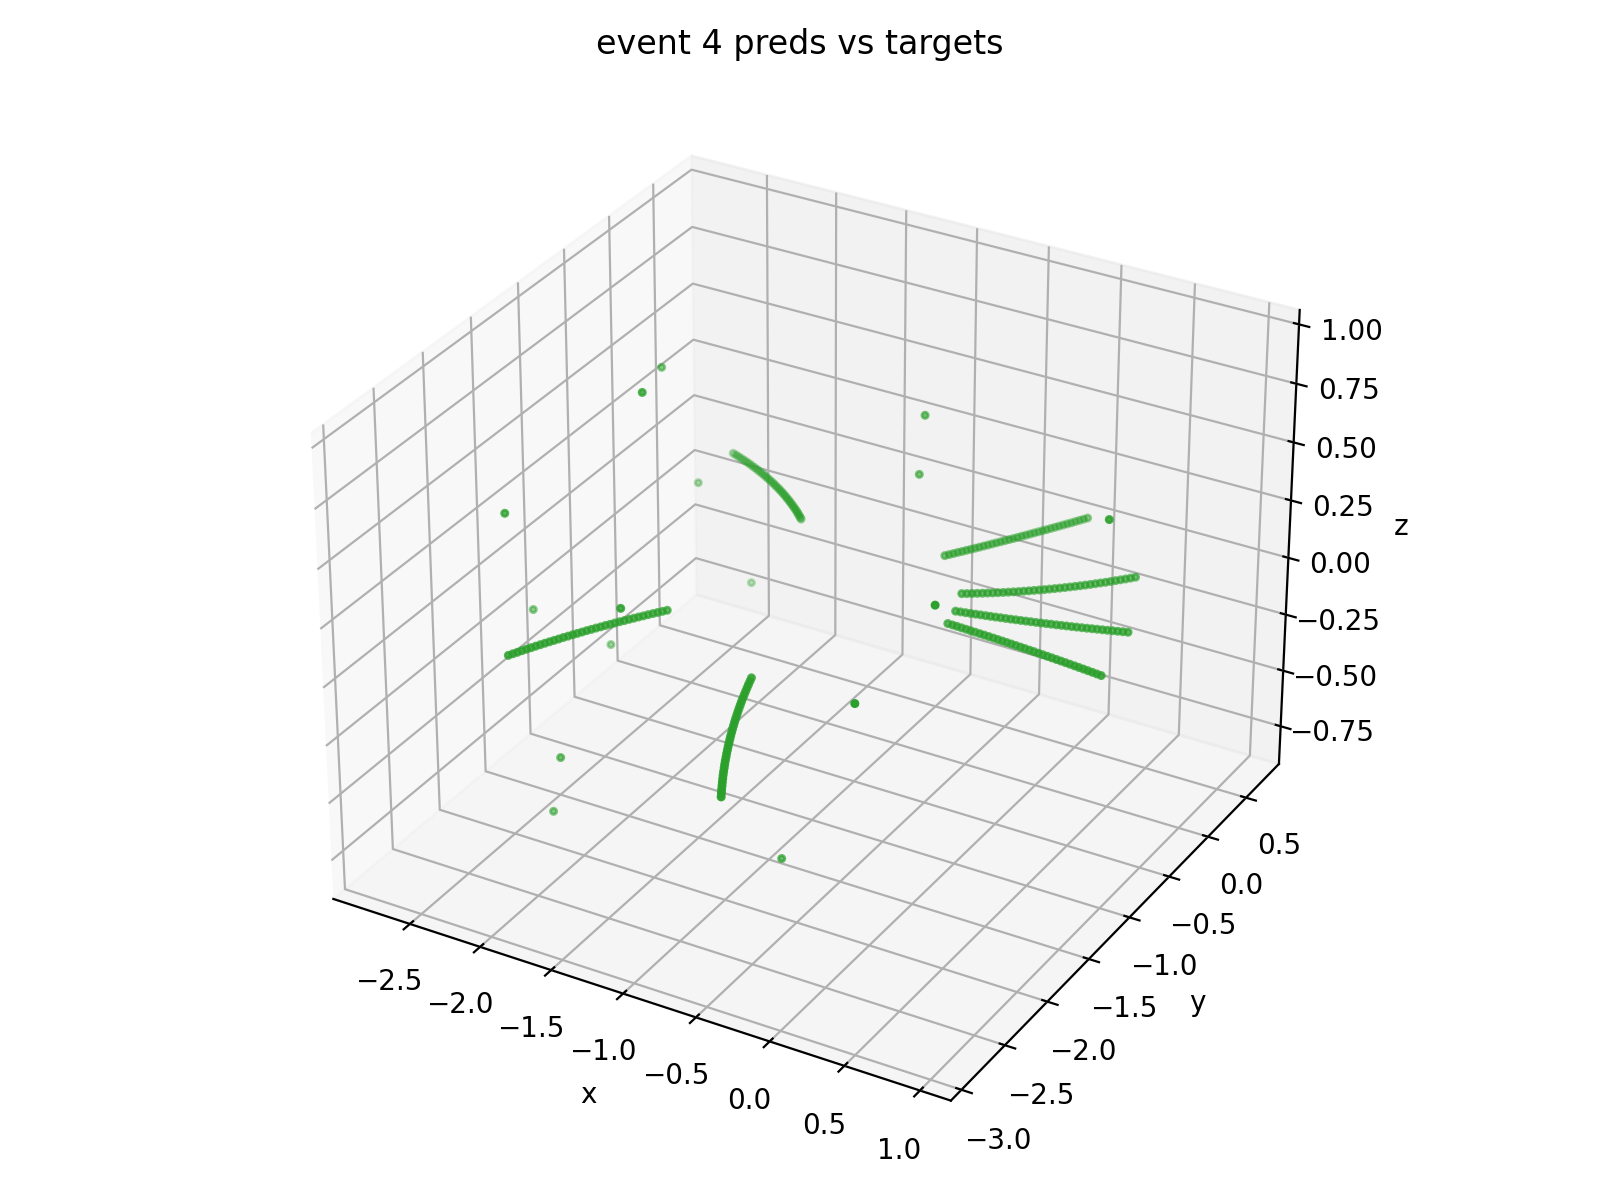

In [46]:
get_results_for_event(4)

Accuracy is 1.0 
Precision is 1.0 
Recall is 1.0 


<IPython.core.display.Javascript object>


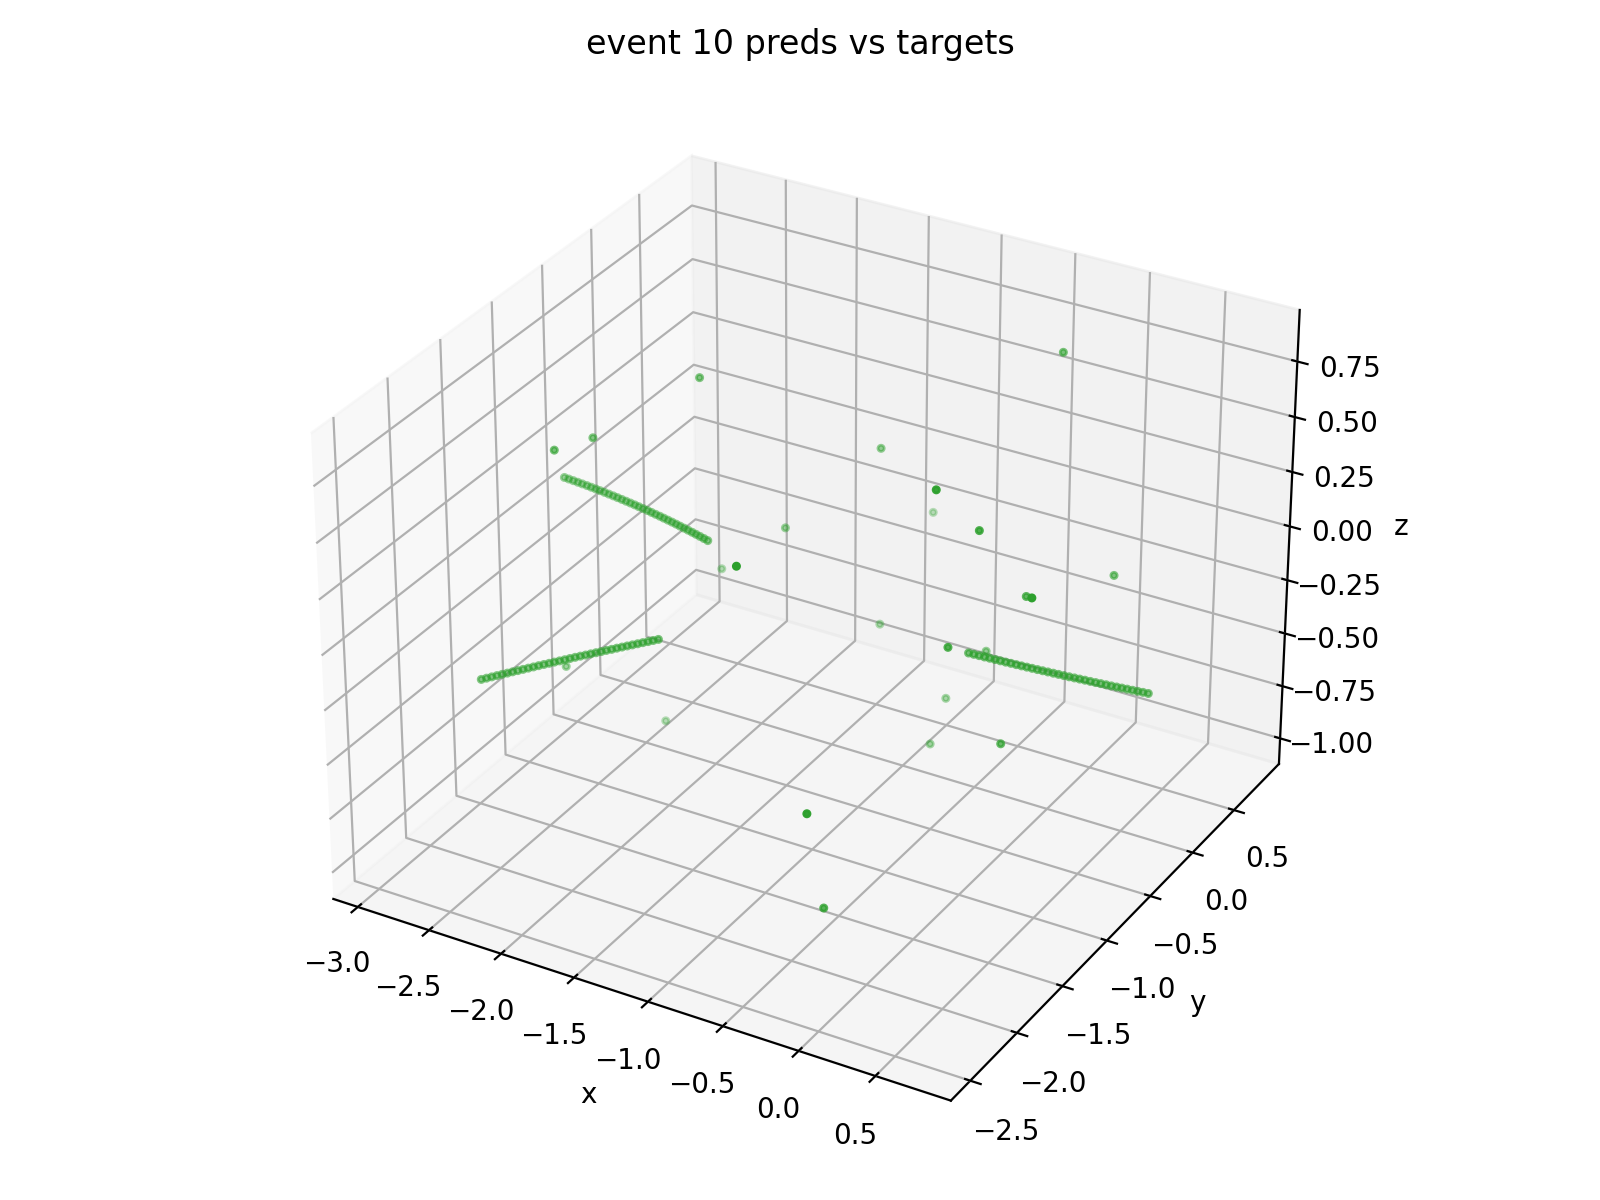

In [48]:
get_results_for_event(10)